In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import

In [2]:
data = "Data_Train.xlsx"

In [3]:
def wrangle(data):
    df = pd.read_excel(data)
    
    #As our dataset have over ten thousand observations, we can remove few dozens of NaN values
    df = df.dropna()
    
    #Extracting Travel Day and Month from the Data_of_Journey column for further use
    df['Travel_day'] = pd.to_datetime(df['Date_of_Journey'], format="%d/%m/%Y").dt.day
    df['Travel_month'] = pd.to_datetime(df['Date_of_Journey'], format="%d/%m/%Y").dt.month
    df = df.drop(columns='Date_of_Journey')
    
    #Extracting Departure Hour and Minutes from the Dep_Time column for further use
    df['Dep_hour'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.hour
    df['Dep_min'] = pd.to_datetime(df['Dep_Time'], format='%H:%M').dt.minute
    df = df.drop(columns='Dep_Time')
    
    #Extracting Arrival Hour and Minutes from the Arrival_Time column for further use
    df['Arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
    df['Arr_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute
    df = df.drop(columns='Arrival_Time')
    
    #Function to extract interger from the column that contains information within the string.
    def duration_hour(duration):
        hour = []
        minute= []
        for data in duration:
            if "h" in data and "m" in data:
                part = data.split(' ')
                hour.append(part[0])
                minute.append(part[1])
            elif "h" in data and "m" not in data:
                hour.append(data)
                minute.append("0m")
            elif "h" not in data and "m" in data:
                hour.append("0h")
                minute.append(data)

        return hour, minute
    df["dur_hour"], df['dur_minutes'] = duration_hour(df["Duration"])
    df = df.drop(columns="Duration")
    
    df['durr_hour'] = df["dur_hour"].str.rstrip('h').astype(int)
    df['durr_minute'] = df["dur_minutes"].str.rstrip('m').astype(int)
    df = df.drop(columns=['dur_hour','dur_minutes'])
    
    #OneHotEncoding of the Total_Stops column
    df["Total_Stops"].replace({'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4}, inplace=True)
    df=df.drop(columns=['Route','Additional_Info'])
    
    return df

In [4]:
df = wrangle(data)

C:\Users\Asad Ali Akhtar\AppData\Local\Temp\ipykernel_2860\2796672989.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Arr_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
C:\Users\Asad Ali Akhtar\AppData\Local\Temp\ipykernel_2860\2796672989.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Arr_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute


# Explore

In [5]:
print(df.shape)
df.head()

(10682, 13)


,Airline,Source,Destination,Total_Stops,Price,Travel_day,Travel_month,Dep_hour,Dep_min,Arr_hour,Arr_min,durr_hour,durr_minute
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,13302,1,3,16,50,21,35,4,45


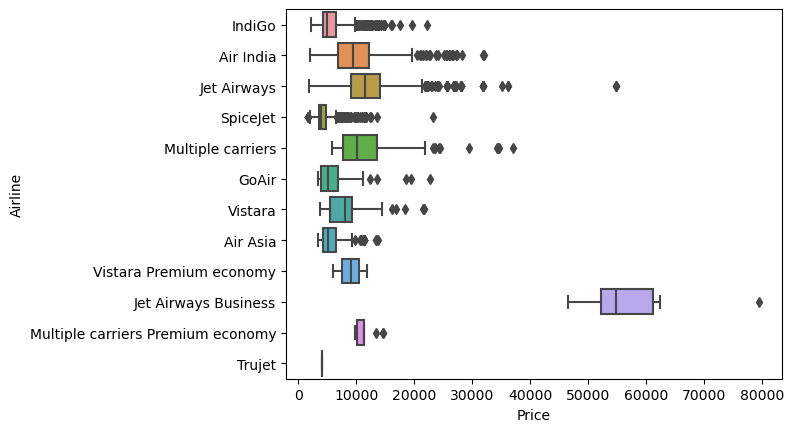

In [6]:
sns.boxplot(x=df['Price'],y=df['Airline']);

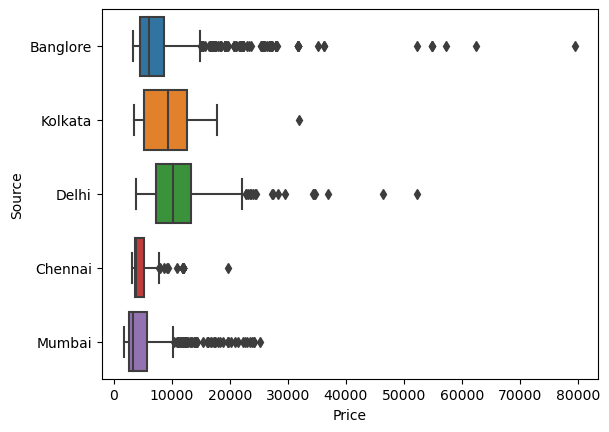

In [7]:
sns.boxplot(x=df['Price'],y=df['Source']);

In [8]:
#seperating object type features form int & float, to check correlation 
map_ = df.iloc[:,3:]

In [9]:
map_.corr()

,Total_Stops,Price,Travel_day,Travel_month,Dep_hour,Dep_min,Arr_hour,Arr_min,durr_hour,durr_minute
Total_Stops,1.000000,0.603897,-0.009451,0.054383,-0.061476,-0.002618,0.038140,-0.106940,0.739916,-0.136706
Price,0.603897,1.000000,-0.153774,-0.103643,0.006799,-0.024458,0.024244,-0.086155,0.508778,-0.124855
Travel_day,-0.009451,-0.153774,1.000000,-0.038359,0.002170,-0.008170,-0.003245,-0.017510,-0.022059,-0.008940
Travel_month,0.054383,-0.103643,-0.038359,1.000000,0.039127,-0.059267,-0.003927,-0.100626,0.016141,-0.040897
Dep_hour,-0.061476,0.006799,0.002170,0.039127,1.000000,-0.024745,0.005180,0.067911,0.002869,-0.023707
Dep_min,-0.002618,-0.024458,-0.008170,-0.059267,-0.024745,1.000000,0.043122,-0.017597,-0.022104,0.092485
Arr_hour,0.038140,0.024244,-0.003245,-0.003927,0.005180,0.043122,1.000000,-0.154363,0.055276,-0.118309
Arr_min,-0.106940,-0.086155,-0.017510,-0.100626,0.067911,-0.017597,-0.154363,1.000000,-0.074450,0.151628
durr_hour,0.739916,0.508778,-0.022059,0.016141,0.002869,-0.022104,0.055276,-0.074450,1.000000,-0.126468
durr_minute,-0.136706,-0.124855,-0.008940,-0.040897,-0.023707,0.092485,-0.118309,0.151628,-0.126468,1.000000


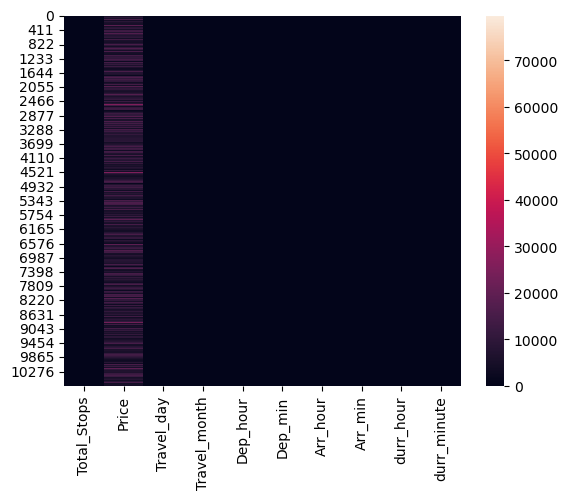

In [10]:
sns.heatmap(map_);

The features and target have a `non-linear relationship` with each other. Keeping it in View, we have to use such ML algorithm that works well with non-linear dataset. e.g. **RandomForestRegressor**"

# Split

In [11]:
X = df.drop(columns='Price')
y = df['Price']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

# Build Model

# Baseline

In [13]:
y_mean = y.mean()
print("Mean absolute Price:", round(y_mean,2))
y_baseline = len(y) * [y_mean]
print("Baseline MAE:", round(mean_absolute_error(y, y_baseline),3))

Mean absolute Price: 9087.21
Baseline MAE: 3655.845


# Iterate

In [14]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    RandomForestRegressor(random_state=42)
)

In [15]:
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Airline', 'Source', 'Destination'],
                               use_cat_names=True)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [16]:
prediction = model.predict(X_test)

# Evaluation

In [17]:
print("Validation MAE:", round(mean_absolute_error(y_test, prediction), 3))

Validation MAE: 1177.74


Our model has `beat` the baseline. 🥳🥳🎉

# Communication

In [18]:
features = model.named_steps["onehotencoder"].get_feature_names()

importance = model.named_steps["randomforestregressor"].feature_importances_

feat_imp = pd.Series(importance, index=features).sort_values()

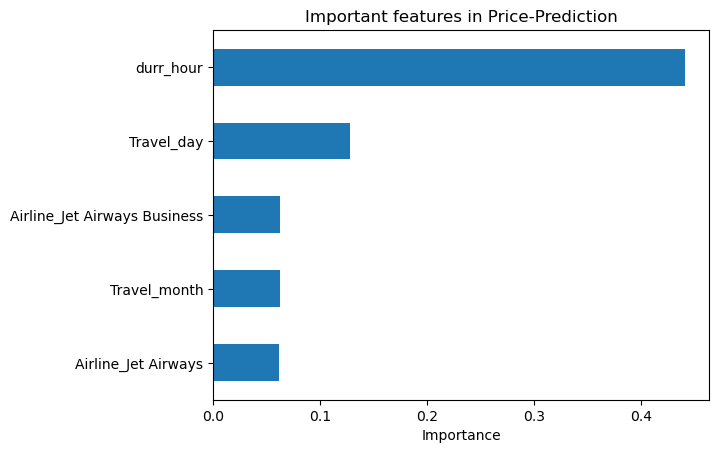

In [19]:
feat_imp.tail().plot(kind="barh")
plt.title("Important features in Price-Prediction")
plt.xlabel("Importance");

In [22]:
#creating a model file for future use and model sharing
with open("RFRegressor_model.pkl", "wb") as f:
    pickle.dump(model, f)